In [2]:
######################################
### Setting up Modules and loading the whole data frame
###################################


### import XPU for my local Intel Laptop 
import torch
import intel_extension_for_pytorch as ipex

### import modules and model 
from transformers import AutoTokenizer, AutoModel
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Select XPU if available, otherwise fallback to CPU
device = torch.device("xpu")
print("Using device:", device)

# specify model and tokenizer
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.to(device)
model.eval() 

# import database 
df = pd.read_pickle ("df_clean.pkl")



from ColorMapping import color_mapping


c:\Users\lucas\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: xpu


In [3]:
##########################
####### Selecting the Subset to be analysed

subset_df = df.sample(n=10000, random_state=42).reset_index(drop=True)    #[(df["year"] >= 1990) & (df["year"] <= 2024)]


In [4]:
############################
###### create Word Embeddings in Latent Space


# Define a helper function to extract the [CLS] embedding for a given text
def get_cls_embedding(text):
    # Tokenize the text with a maximum length of 512 tokens (truncation applied)
    inputs = tokenizer(text, max_length=512, truncation=True, return_tensors="pt")
    # Move inputs to the device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the [CLS] token embedding (first token in the sequence)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, hidden_size)
    # Remove the batch dimension and convert to numpy array
    return cls_embedding.squeeze(0).cpu().numpy()

# experimenting with a few Scaling Methods 
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
# embeddings = scaler.fit_transform(raw_embeddings)

# Generate embeddings for each abstract in the sample
embeddings =[get_cls_embedding(abstract) for abstract in subset_df["abstract"]]
embeddings = np.array(embeddings)
print("Embeddings shape:", embeddings.shape)


Embeddings shape: (10000, 768)


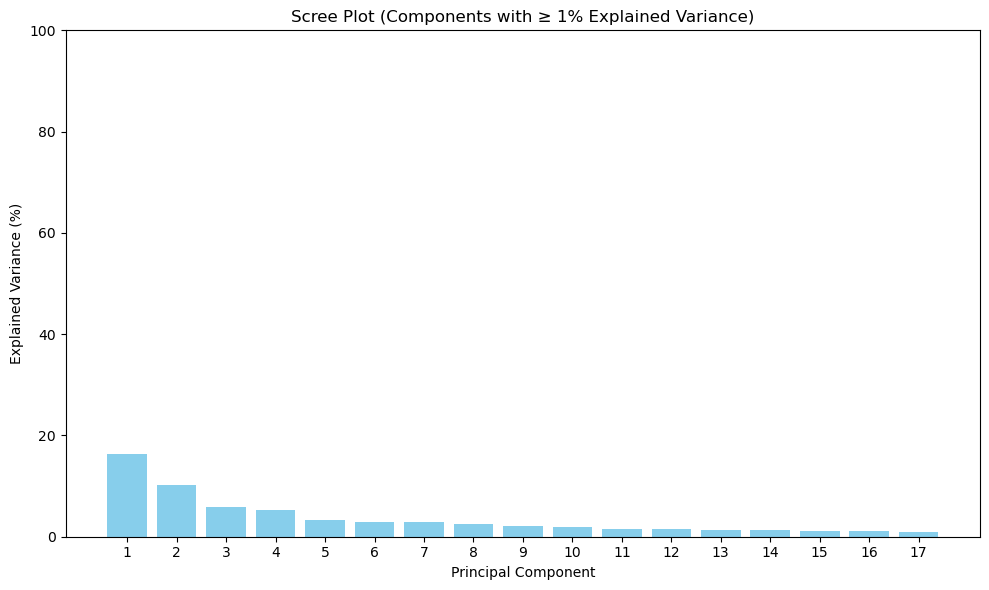

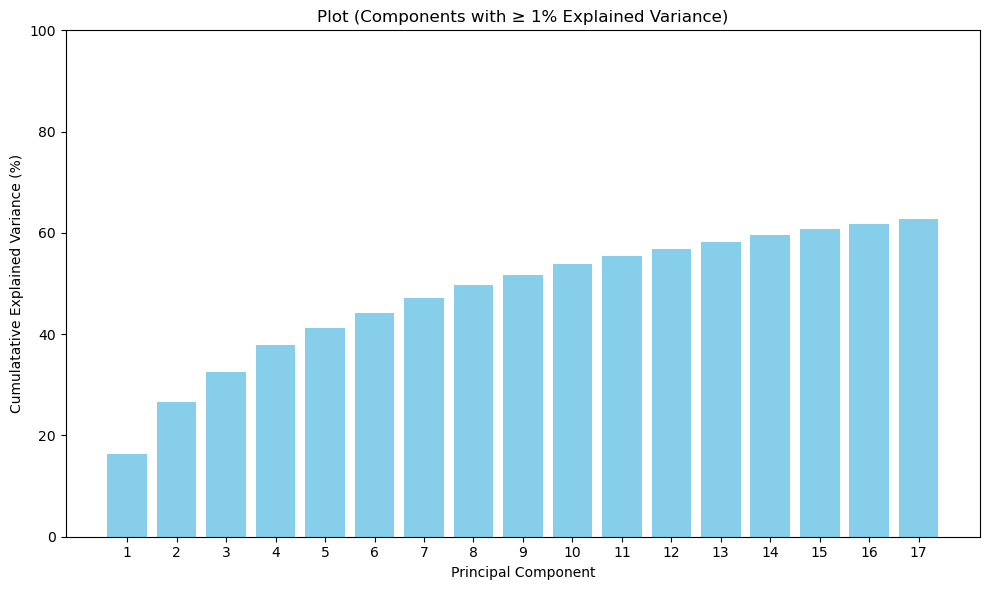

In [5]:
##########################################
####### Run a PCA and estimate Explained Variance incl. Scree Plot

from sklearn.decomposition import PCA

# Run full PCA on the embeddings ()
pca= PCA().fit(embeddings)

# define explained and create enumarated array 
explained_variance = pca.explained_variance_ratio_ * 100  # convert to percentages
components = np.arange(1, len(explained_variance) + 1)

# Filter to include only components with >= 1% explained variance
mask = explained_variance >= 1
filtered_components = components[mask]
filtered_explained_variance = explained_variance[mask]

# Plot the scree plot using only filtered components
plt.figure(figsize=(10, 6))
plt.bar(filtered_components, filtered_explained_variance, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Scree Plot (Components with ≥ 1% Explained Variance)')
plt.xticks(filtered_components)
plt.ylim(0,100)
plt.tight_layout()
plt.show()

########## create cumulatative scree plot 
cumulative_varianve_explained = np.cumsum(filtered_explained_variance)

#plot cumulative variance
plt.figure(figsize=(10, 6))
plt.bar(filtered_components,cumulative_varianve_explained, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Cumulatative Explained Variance (%)')
plt.title('Plot (Components with ≥ 1% Explained Variance)')
plt.xticks(filtered_components)
plt.ylim(0,100)
plt.tight_layout()
plt.show()

Number of publications from 2000 to 2001: 206


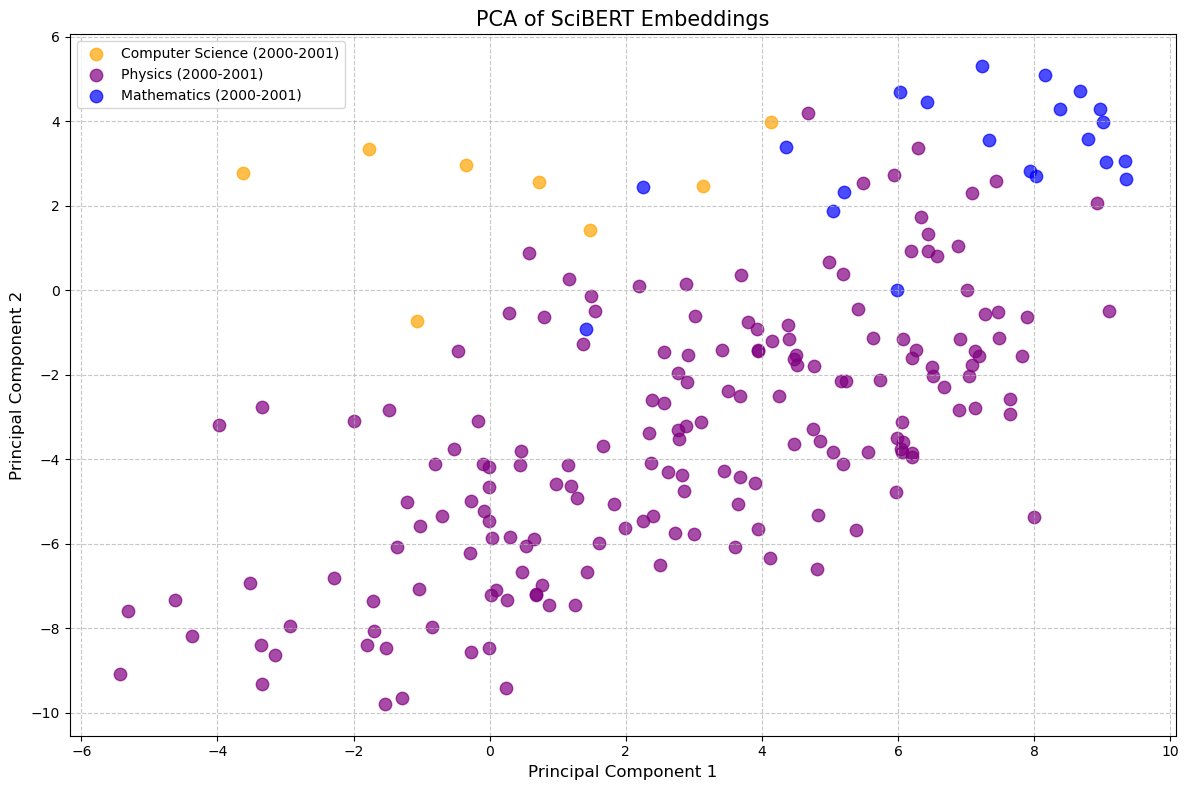

Number of publications from 2002 to 2003: 277


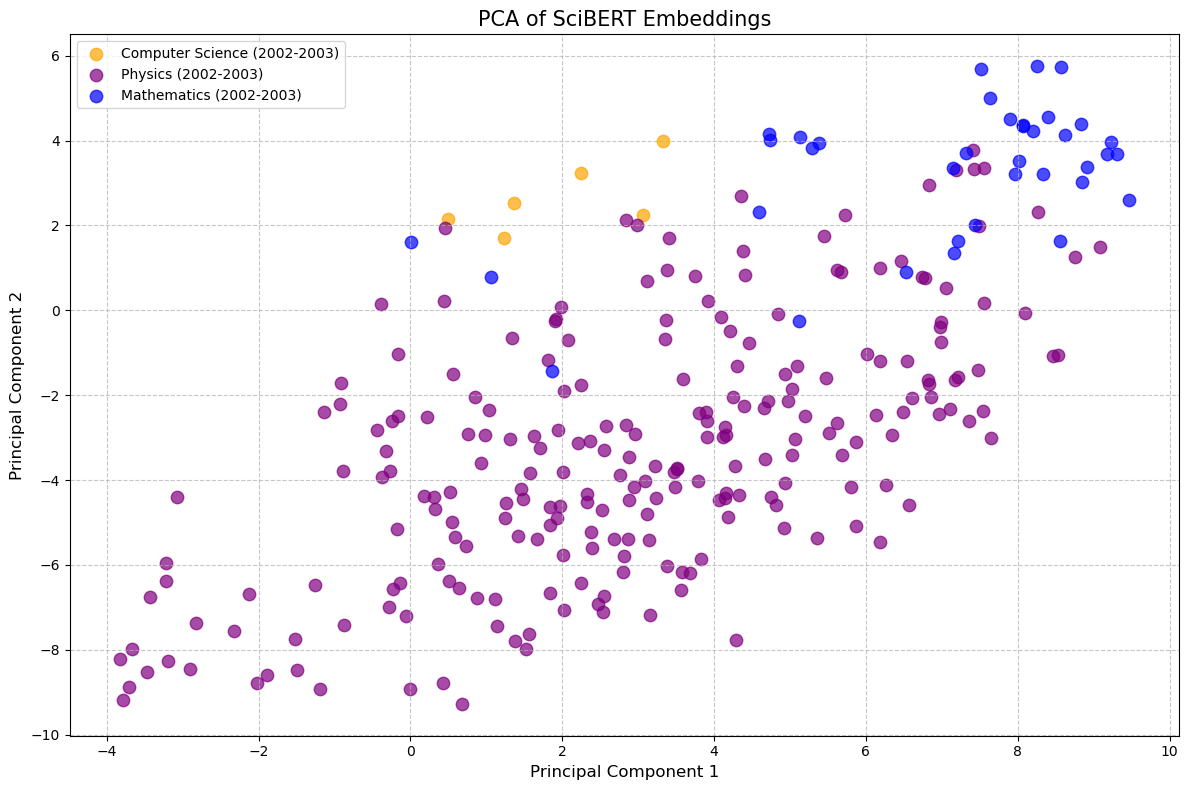

Number of publications from 2004 to 2005: 330


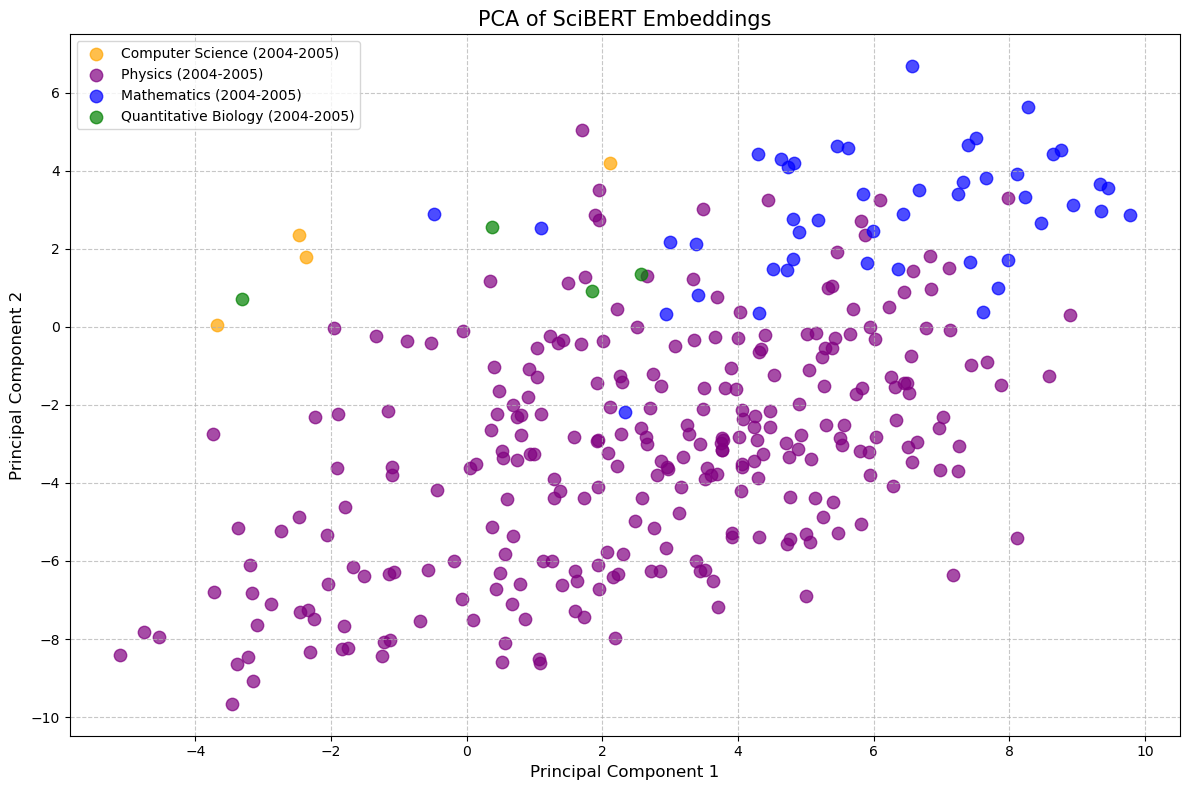

Number of publications from 2023 to 2024: 1682


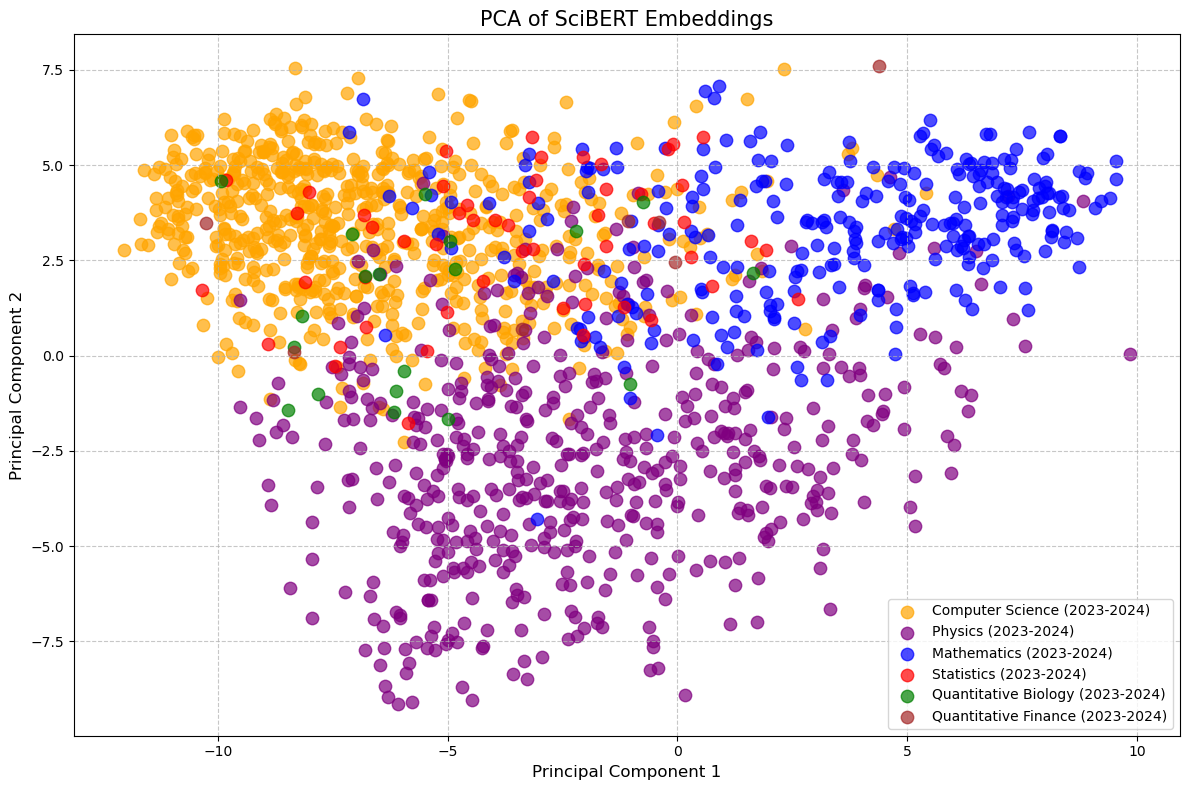

Number of publications from 2025 to 2025: 183


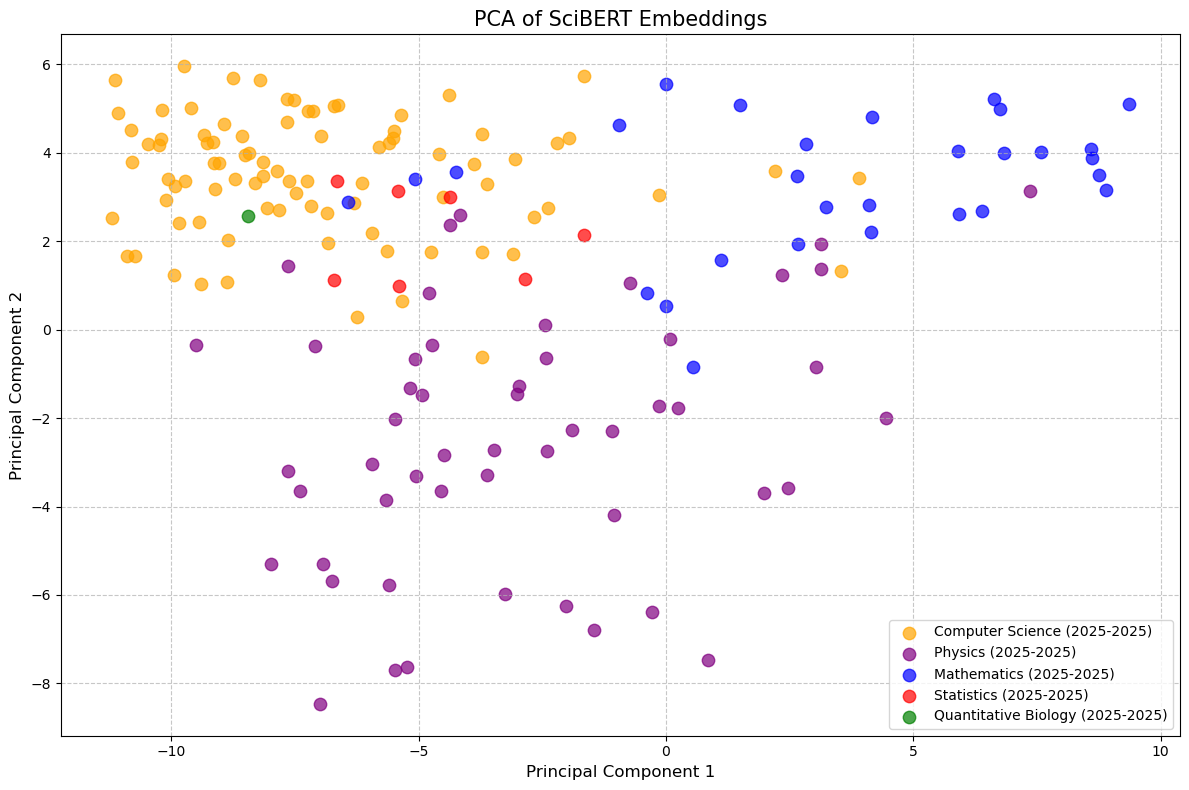

PC1 explains 16.30% of the variance
PC2 explains 10.26% of the variance
Together they explain 26.56% of the variance


In [6]:
############################
###### plot PCA with colors 

pca_projection = pca.transform(embeddings)


# Get unique fields for the plot
unique_fields = subset_df["field"].unique()
# define year bins
year_bins = [(2000, 2001), (2002, 2003), (2004, 2005), (2023, 2024), (2025, 2025)]

for start,end in year_bins: 
    plt.figure(figsize=(12, 8))
    # create mask_years to be able to iterate through each year
    mask_years = (subset_df["year"] >= start) & (subset_df["year"] <= end)
    # creating year bin
    df_binned_years = subset_df[mask_years]
    print(f"Number of publications from {start} to {end}: {len(df_binned_years)}")

    # Plot each field with its specific color from the color mapping
    for field in unique_fields:
        if field in color_mapping:  # Check if the field is in our color mapping
            # Create a combined mask for both year range and field
            combined_mask = mask_years & (subset_df["field"] == field)
            # Only plot if there are any points matching the criteria
            if combined_mask.any():
                plt.scatter(
                    pca_projection[combined_mask, 0],  # PC1
                    pca_projection[combined_mask, 1],  # PC2
                    label=f"{field} ({start}-{end})",  # Add year range to label
                    color=color_mapping[field],
                    alpha=0.7,
                    s=80  # Point size
                )

    plt.title("PCA of SciBERT Embeddings", fontsize=15)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Print the explained variance for the first two components
pc1_variance = explained_variance[0]
pc2_variance = explained_variance[1]
print(f"PC1 explains {pc1_variance:.2f}% of the variance")
print(f"PC2 explains {pc2_variance:.2f}% of the variance")
print(f"Together they explain {pc1_variance + pc2_variance:.2f}% of the variance")




In [7]:
#############################
### creating embedded vectors of official subcategories  as a reference using SciBert

# create dataframe from pickle file
df_cats_map = pd.read_pickle("df_cats_map.pkl")

embedding_sources = []  #Only used to verify if else statement is working properly, could be removed

# Generate embeddings for each category, using long_description if available, otherwise short_description
embeddings_cat = []
for _, row in df_cats_map.iterrows():
    # Use long_description if it is not just a placeholder text
    if  "Description coming soon" not in row['long_description']:
        embedding_sources.append("long")
        embeddings_cat.append(get_cls_embedding(row['long_description']))
    else:
        embedding_sources.append("short")
        embeddings_cat.append(get_cls_embedding(row['short_description']))

embeddings_cat = np.array(embeddings_cat)
print("Embeddings shape:", embeddings_cat.shape)

# Create a summary of which descriptions were used
source_counts = pd.Series(embedding_sources).value_counts()
print("Count of descriptions used:")
print(source_counts)

Embeddings shape: (155, 768)
Count of descriptions used:
long     151
short      4
Name: count, dtype: int64


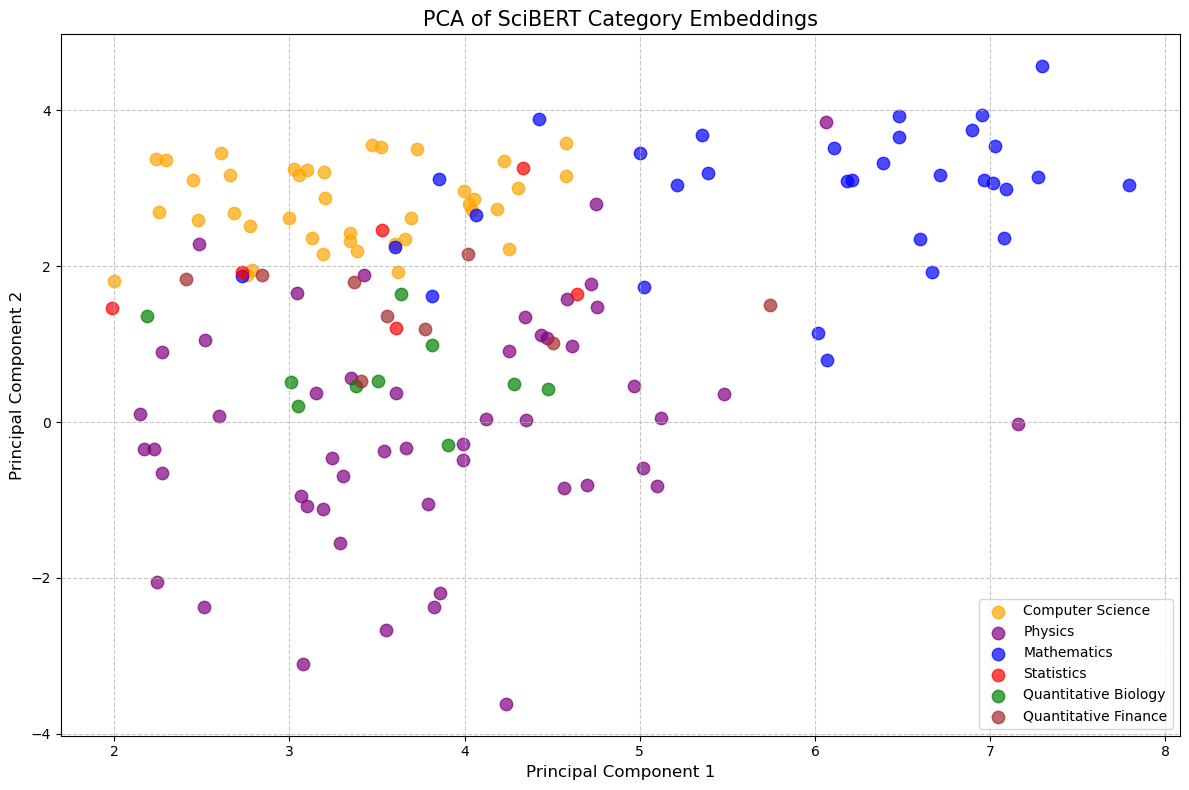

In [16]:
##########################
#### plotting embeddings_cat in the same PCA and same way 

pca_projection_cats = pca.transform(embeddings_cat)

# Create a figure for plotting category embeddings
plt.figure(figsize=(12, 8))

for field in unique_fields:
    if field in color_mapping and not pd.isna(field):  # Check if the field is in our color mapping and not NaN
        # Create a mask for the current field in df_cats_map
        mask_cats = (df_cats_map["field"] == field)
        # Only plot if there are any points matching the criteria
        if mask_cats.any():
            plt.scatter(
                pca_projection_cats[mask_cats, 0],  # PC1
                pca_projection_cats[mask_cats, 1],  # PC2
                label=field,  # Simply use the field name
                color=color_mapping[field],
                alpha=0.7,
                s=80  # Point size
            )

plt.title("PCA of SciBERT Category Embeddings", fontsize=15)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Share of publications in 2016 by primary category (top 5):
primary_category
hep-ph               0.047619
quant-ph             0.040816
cond-mat.mes-hall    0.040816
math.PR              0.038549
astro-ph.GA          0.034014
Name: count, dtype: float64


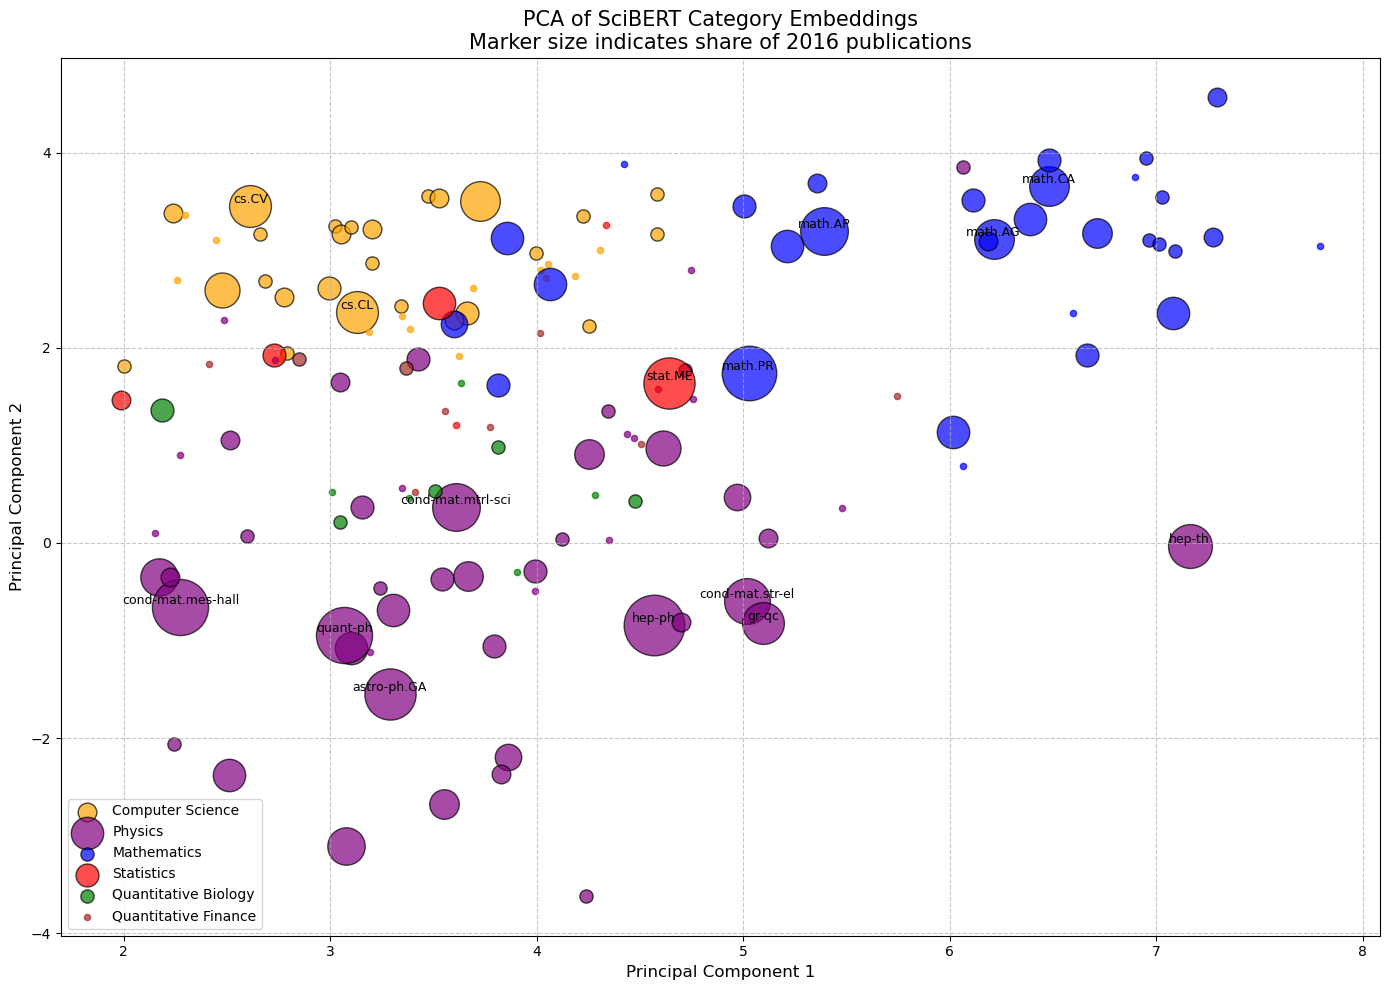


Share of publications in 2017 by primary category (top 5):
primary_category
cs.CV                0.047619
cond-mat.mtrl-sci    0.037267
quant-ph             0.035197
hep-ph               0.033126
gr-qc                0.026915
Name: count, dtype: float64


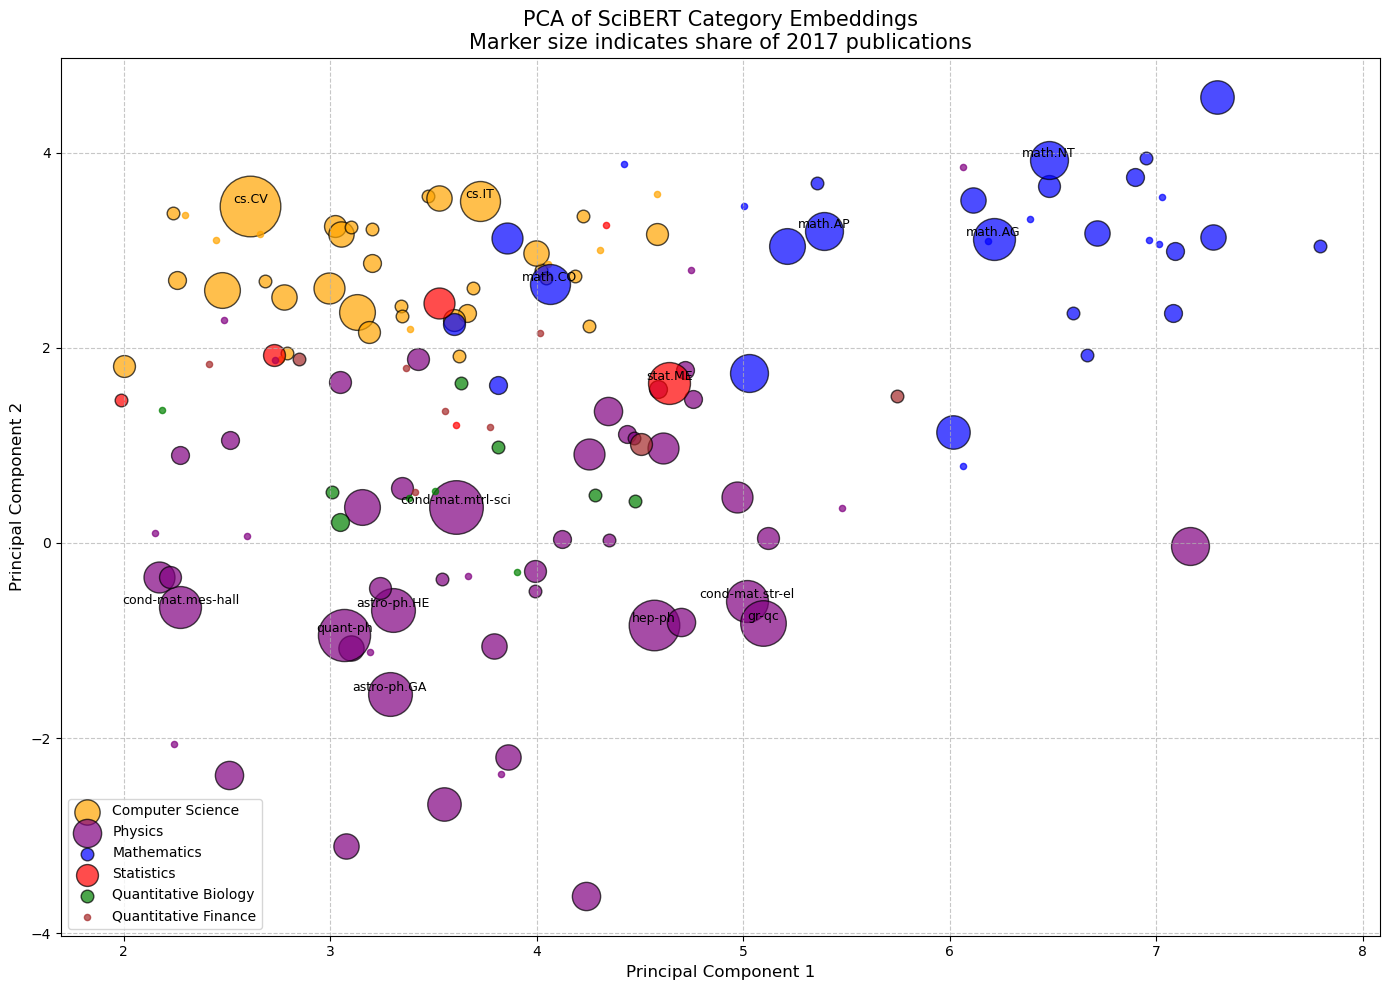


Share of publications in 2018 by primary category (top 5):
primary_category
cs.CV       0.063008
hep-ph      0.040650
cs.CL       0.040650
quant-ph    0.030488
math.CO     0.030488
Name: count, dtype: float64


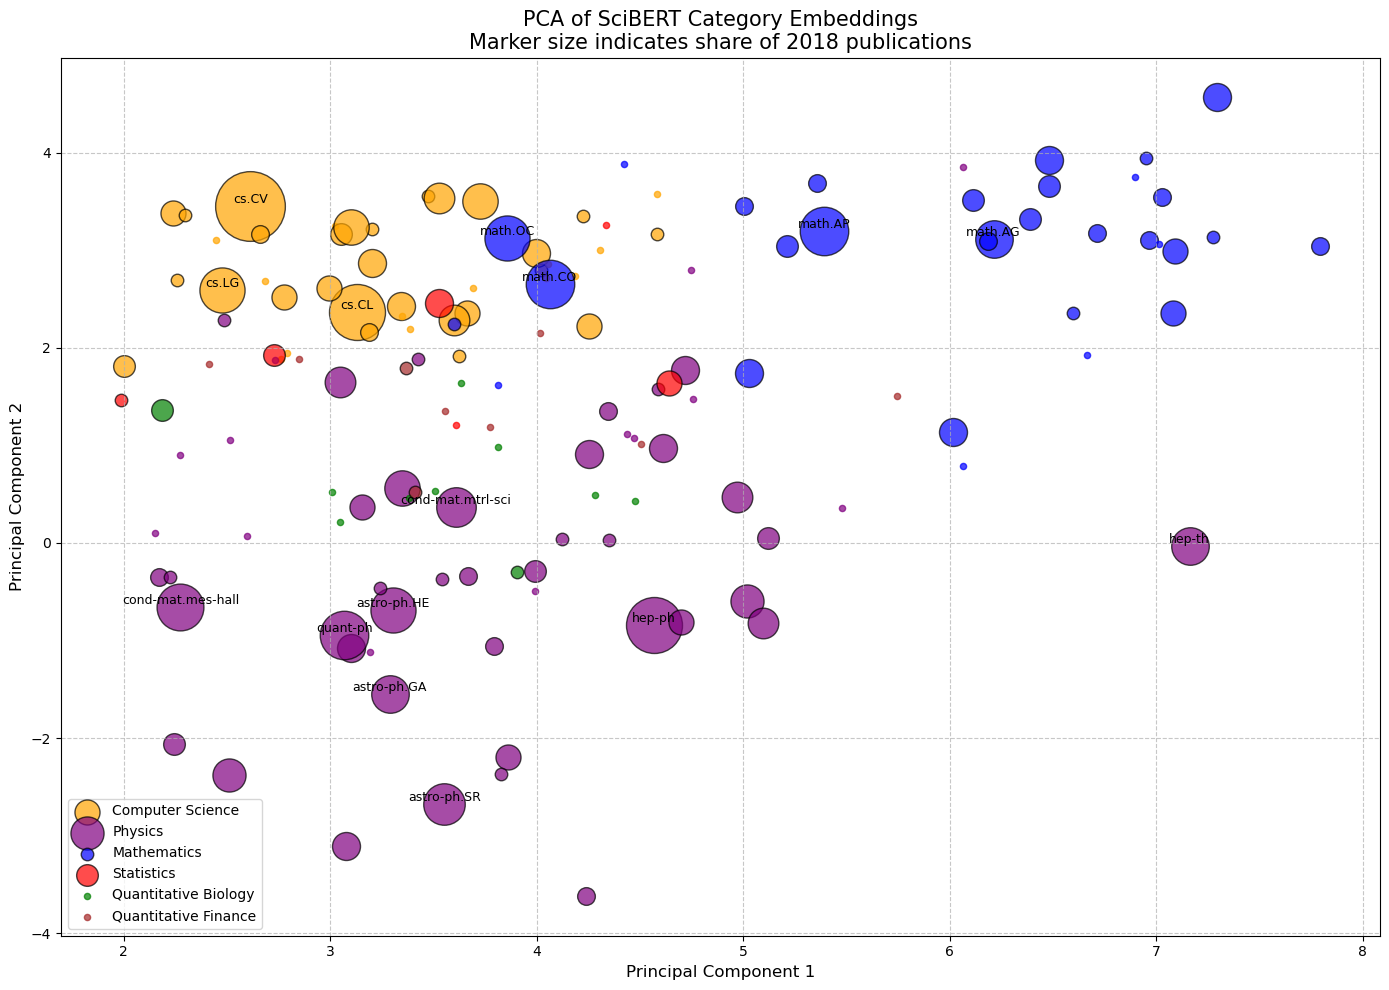


Share of publications in 2019 by primary category (top 5):
primary_category
cs.LG       0.056478
cs.CV       0.043189
quant-ph    0.034884
cs.CL       0.029900
math.AP     0.026578
Name: count, dtype: float64


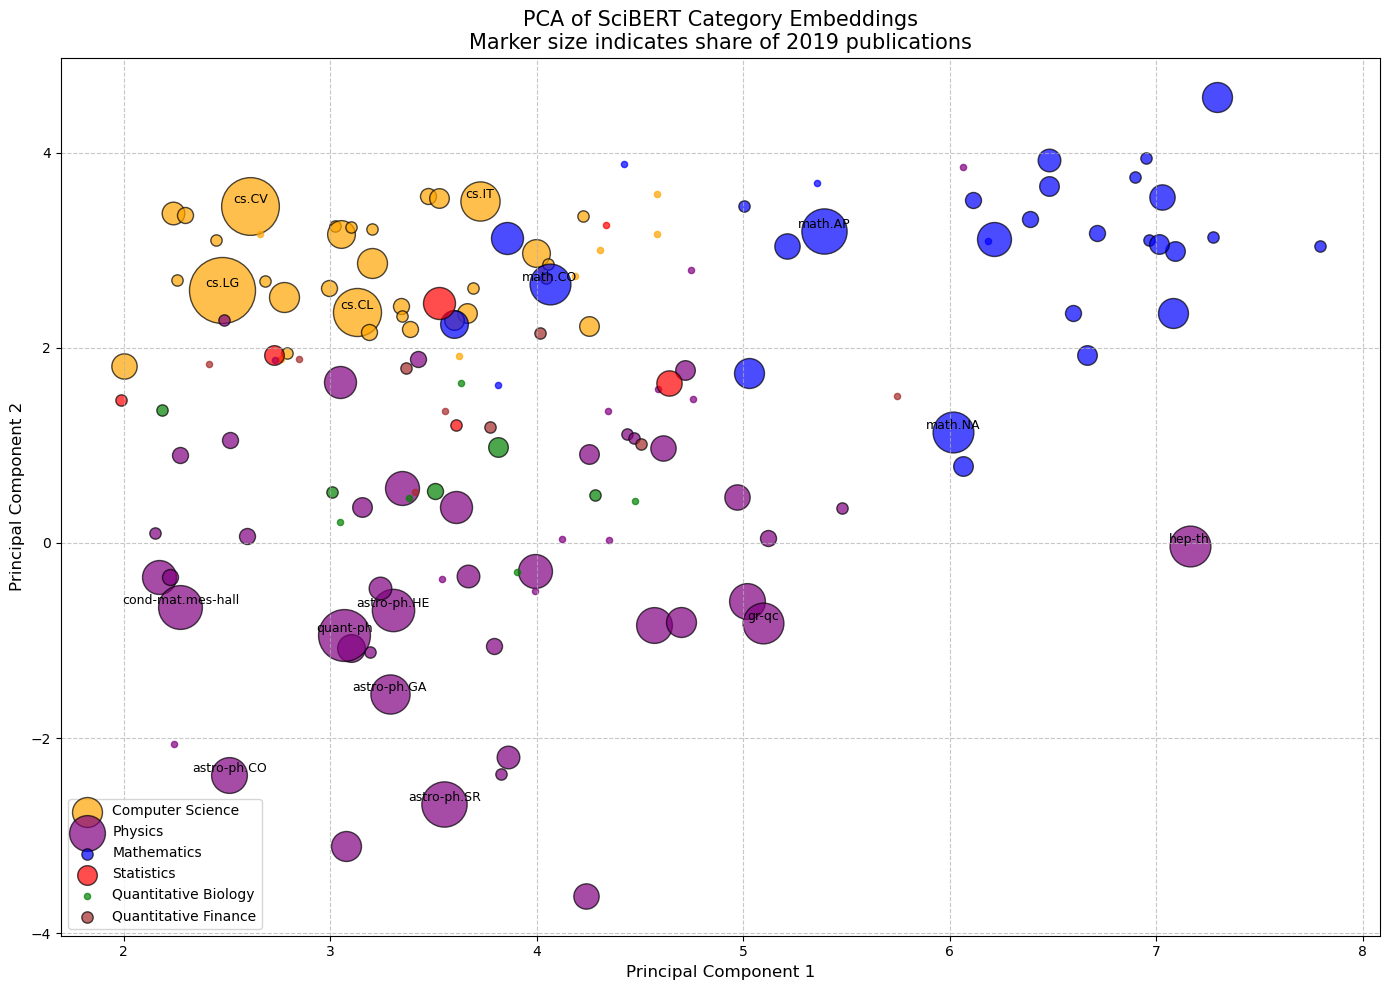


Share of publications in 2020 by primary category (top 5):
primary_category
cs.LG          0.075758
cs.CV          0.072727
quant-ph       0.036364
astro-ph.GA    0.031818
hep-th         0.028788
Name: count, dtype: float64


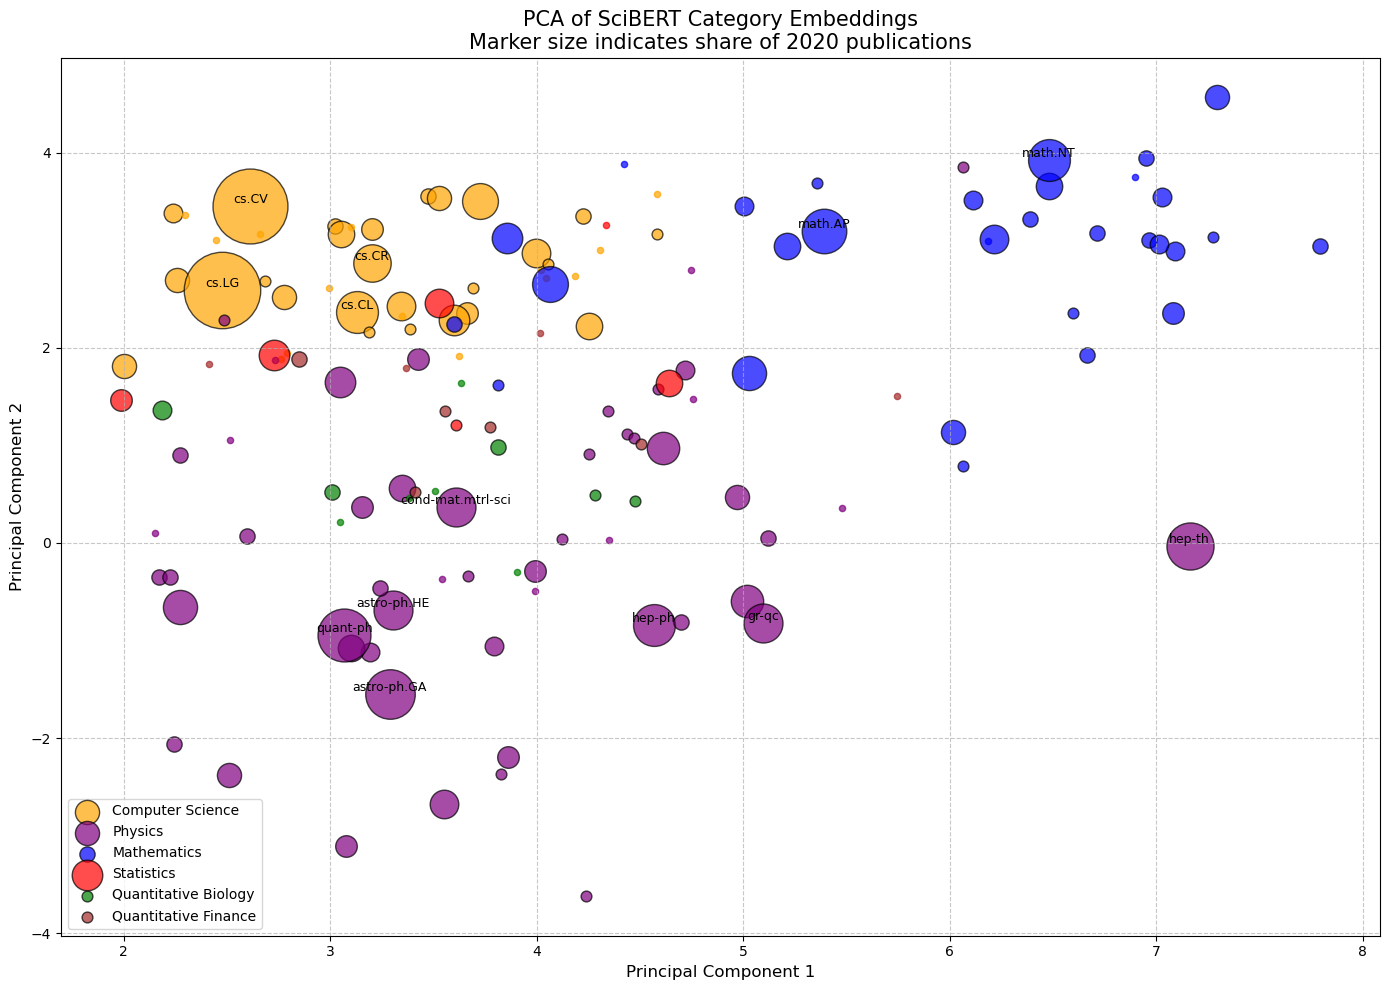


Share of publications in 2021 by primary category (top 5):
primary_category
cs.CV       0.079320
cs.LG       0.066572
hep-th      0.035411
math.AP     0.033994
quant-ph    0.032578
Name: count, dtype: float64


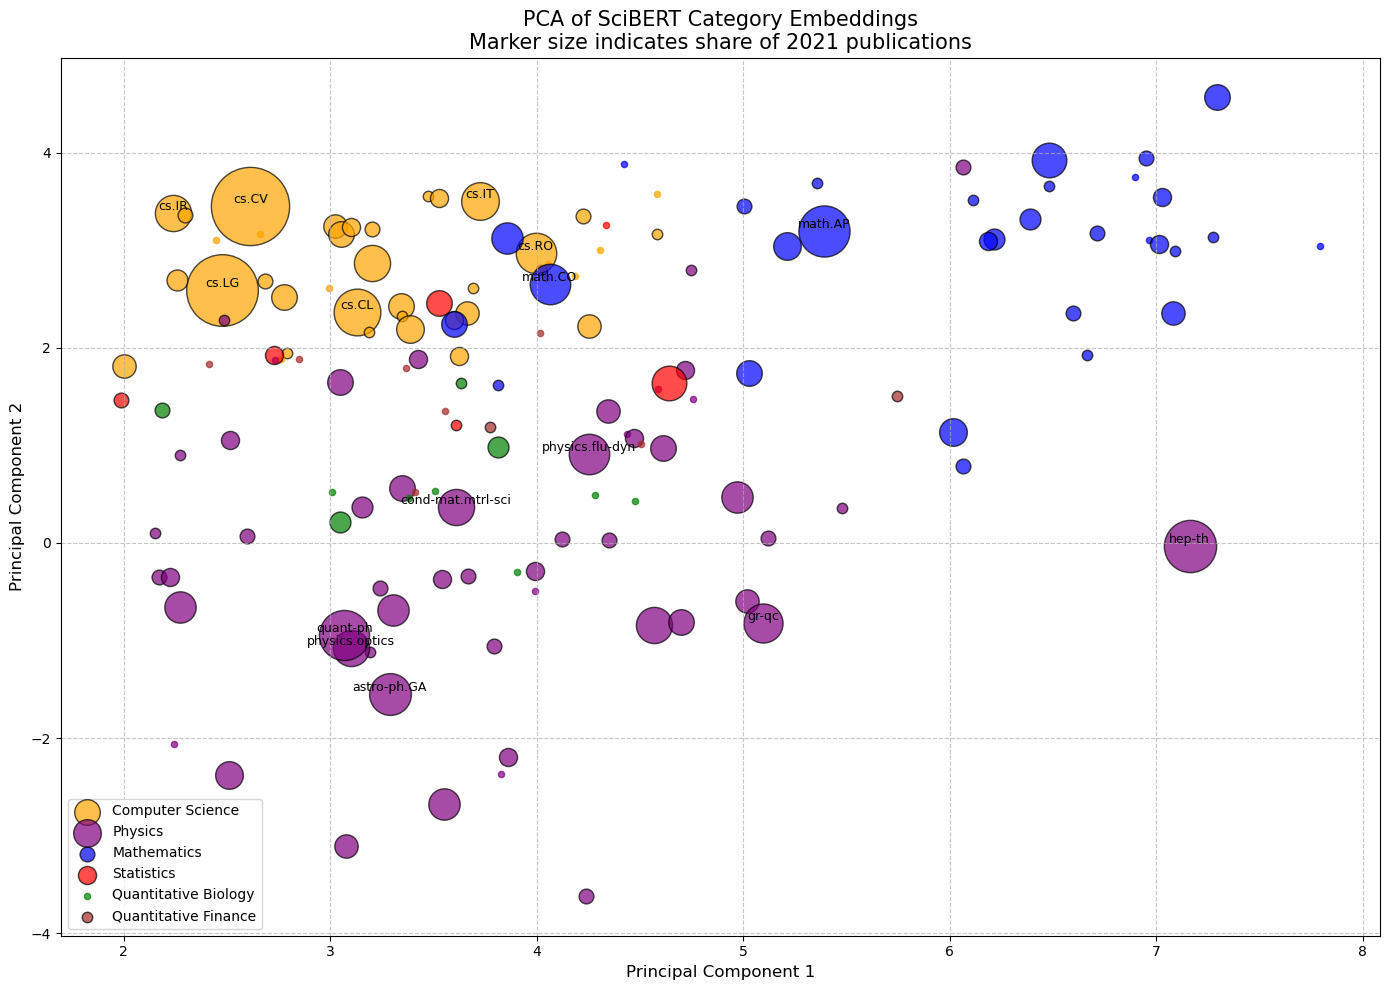


Share of publications in 2022 by primary category (top 5):
primary_category
cs.CV       0.089368
cs.LG       0.064715
quant-ph    0.049307
cs.CL       0.040062
hep-ph      0.033898
Name: count, dtype: float64


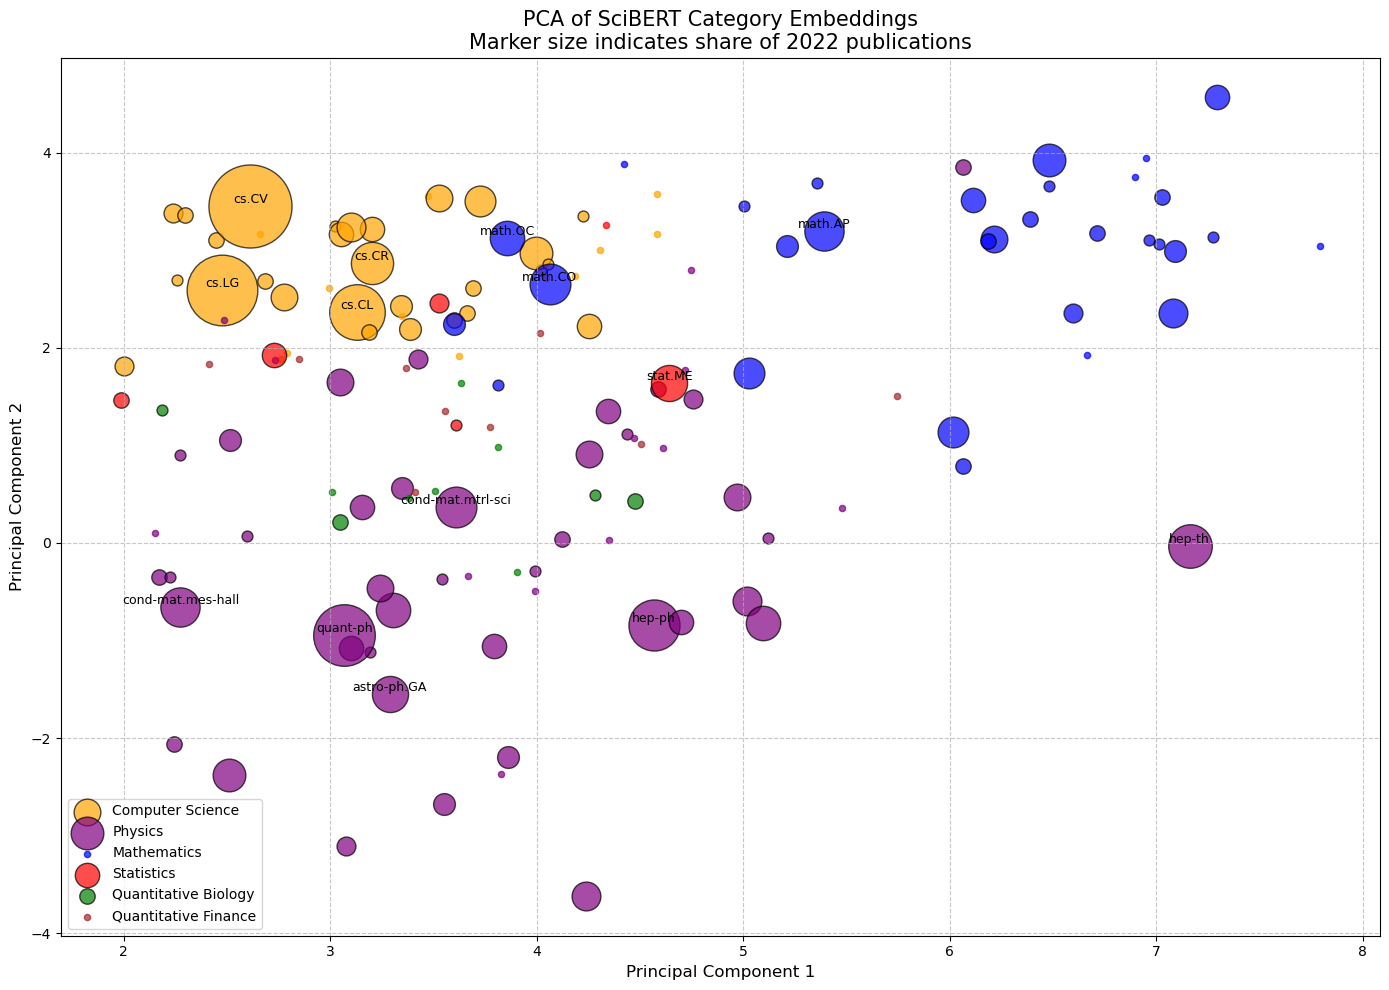


Share of publications in 2023 by primary category (top 5):
primary_category
cs.CV       0.085639
cs.LG       0.079051
cs.CL       0.043478
quant-ph    0.039526
math.AP     0.026350
Name: count, dtype: float64


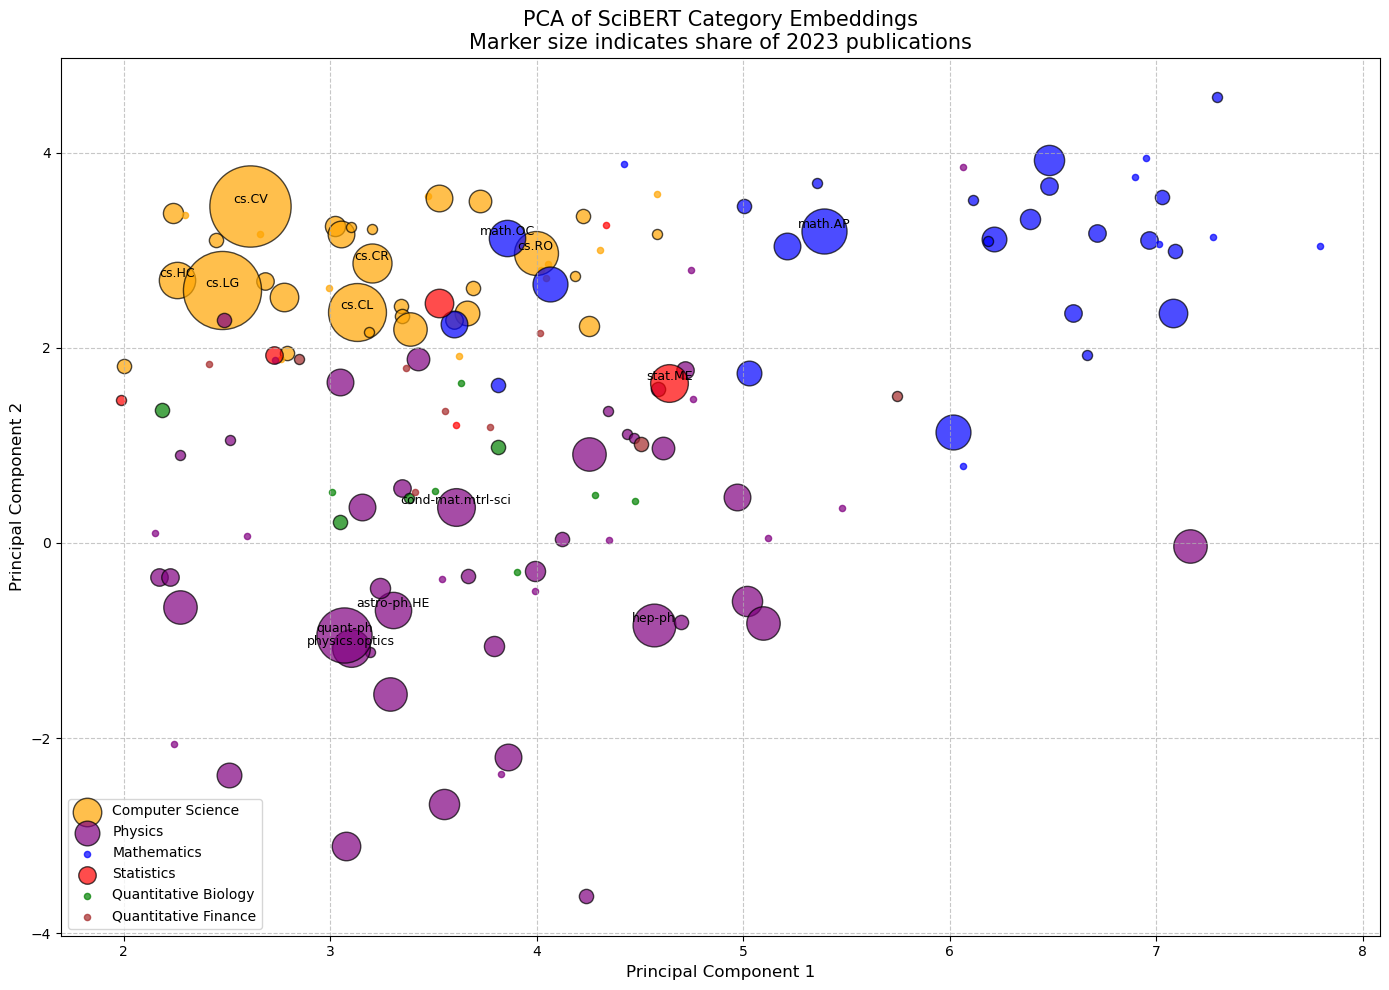


Share of publications in 2024 by primary category (top 5):
primary_category
cs.CV       0.104009
cs.CL       0.073673
cs.LG       0.067172
quant-ph    0.030336
cs.RO       0.027086
Name: count, dtype: float64


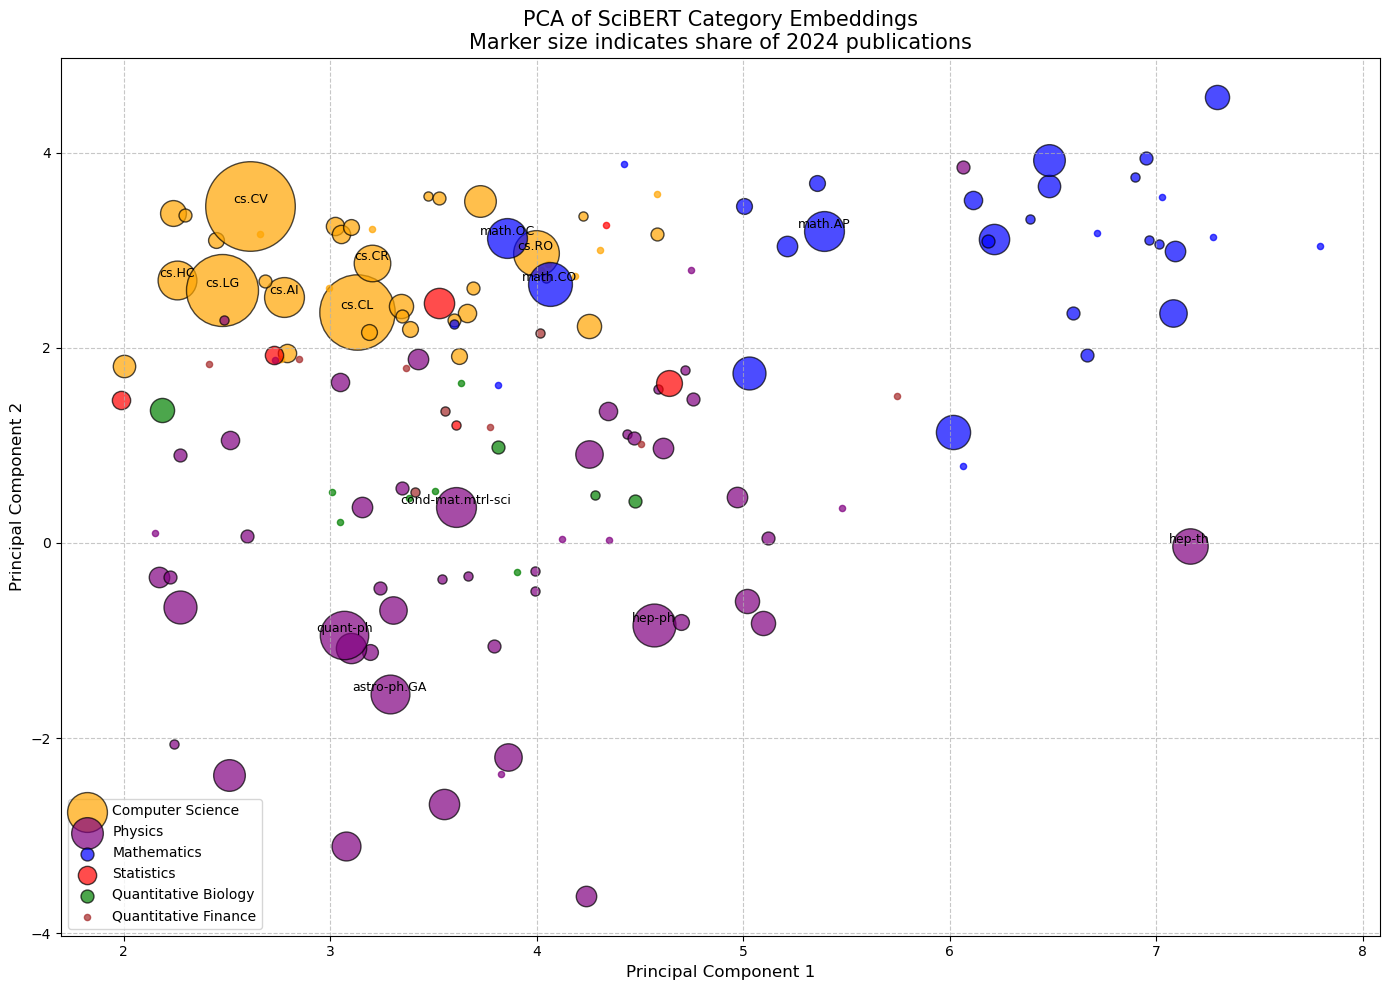


Share of publications in 2025 by primary category (top 5):
primary_category
cs.LG       0.109290
cs.CV       0.087432
cs.CL       0.076503
quant-ph    0.054645
math.AP     0.027322
Name: count, dtype: float64


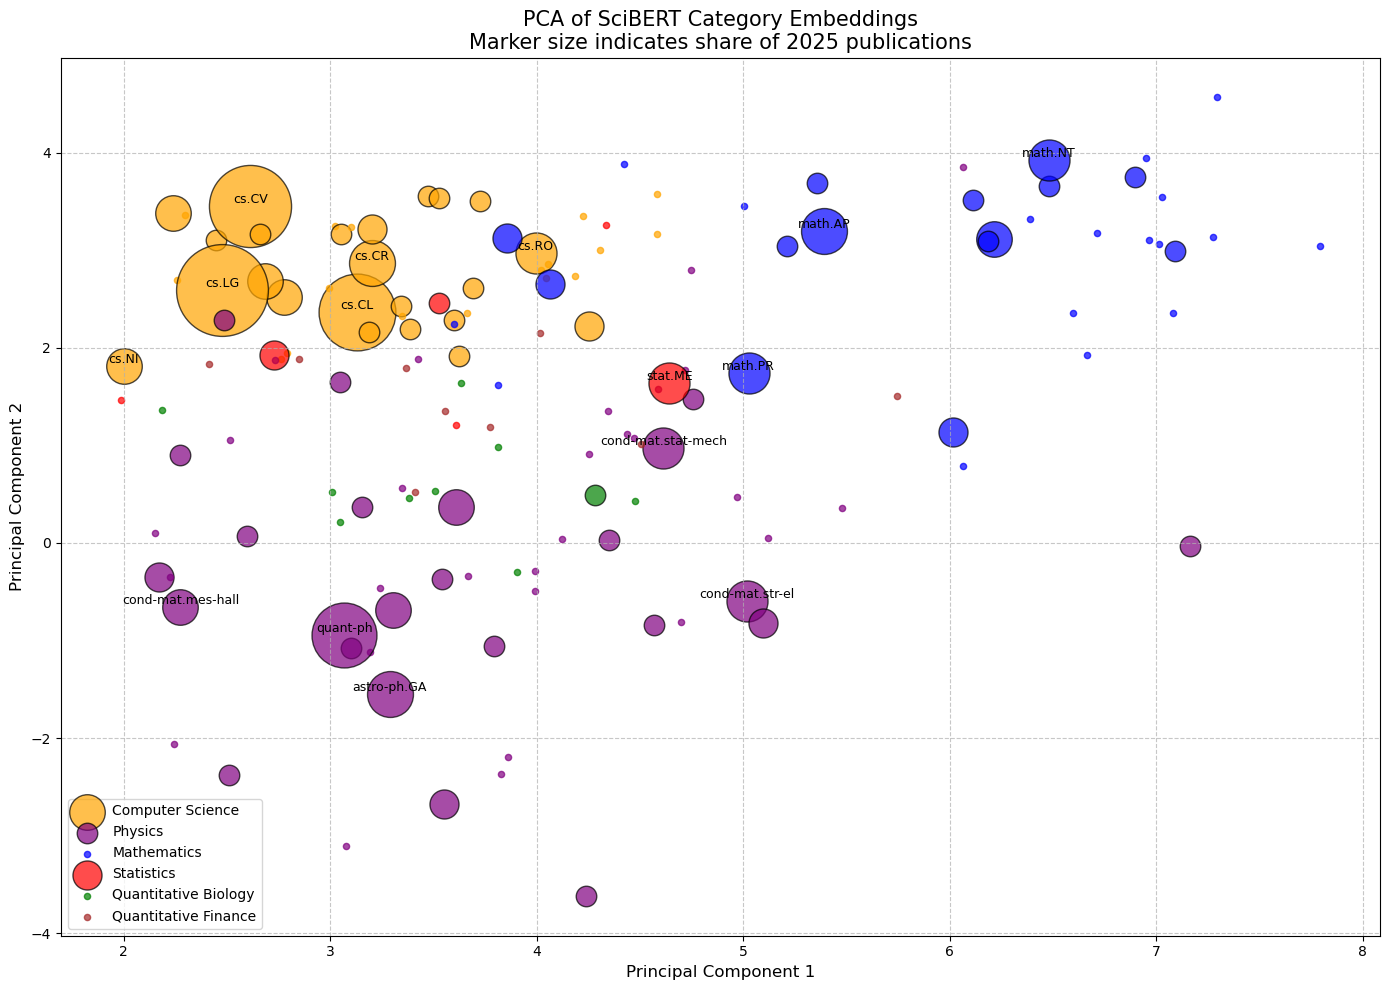

In [ ]:
##########################
### Plot embeddings_cat based on each categories share of publications for multiple years

from matplotlib.lines import Line2D

# Define years to analyze (last 10 years)
years_to_analyze = list(range(2016, 2026))  # 2016-2025

# Loop through each year
for year in years_to_analyze:
    # Get publications from the current year
    pubs_year = subset_df[subset_df["year"] == year]
    
    # Check if there are any publications for this year
    if len(pubs_year) == 0:
        print(f"No publications found for year {year} in the subset")
        continue
    
    # Calculate share for each primary category
    category_counts = pubs_year["primary_category"].value_counts()
    total_pubs = len(pubs_year)
    category_shares = category_counts / total_pubs

    print(f"\nShare of publications in {year} by primary category (top 5):")
    print(category_shares.nlargest(5))
    
    # Create mapping from category to marker size based on share
    category_sizes = {}
    for cat in category_counts.index:
        share = category_shares.get(cat, 0)
        # Convert share to marker size (manually chosen scaling factor)
        category_sizes[cat] = 40000 * share
    
    # Create a figure for plotting category embeddings
    plt.figure(figsize=(14, 10))
    
    # Plot each field with appropriate color and marker size
    for field in unique_fields:
        if field in color_mapping and not pd.isna(field):
            # Create a mask for the current field in df_cats_map
            mask_cats = (df_cats_map["field"] == field)
            
            # Only plot if there are points matching the criteria
            if mask_cats.any():
                # For each category in this field
                for i, row_idx in enumerate(df_cats_map.index[mask_cats]):
                    category = df_cats_map.loc[row_idx, "category"]
                    
                    # Determine marker size based on publication share
                    size = category_sizes.get(category, 20)  # Default small size if no publications
                    
                    # Plot with size reflecting publication share
                    plt.scatter(
                        pca_projection_cats[row_idx, 0],  # PC1
                        pca_projection_cats[row_idx, 1],  # PC2
                        label=field if i == 0 else "",  # Only include field in legend once
                        color=color_mapping[field],
                        alpha=0.7,
                        s=size,  # Use size based on share
                        edgecolors="black" if category in category_counts.index else None
                    )
                    
                    # Annotate with category name for significant categories (top 15)
                    if category in category_counts.nlargest(15).index:
                        plt.annotate(
                            category,
                            (pca_projection_cats[row_idx, 0], pca_projection_cats[row_idx, 1]),
                            fontsize=9,
                            ha='center',
                            va='bottom'
                        )
    
    plt.title(f"PCA of SciBERT Category Embeddings\nMarker size indicates share of {year} publications", fontsize=15)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [9]:
############################
### MDS Attempt
'''
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold

mds = MDS (n_components=2, random_state=0)
mds_projection = mds.fit_transform(embeddings)

# Plot the MDS projection
plt.figure(figsize=(12, 8))

# Get unique fields for the plot
unique_fields = subset_df["field"].unique()

# Plot each field with its specific color from the color mapping
for field in unique_fields:
    if field in color_mapping:  # Check if the field is in our color mapping
        mask = subset_df["field"] == field
        plt.scatter(
            mds_projection[mask, 0],  # MDS dimension 1
            mds_projection[mask, 1],  # MDS dimension 2
            label=field,
            color=color_mapping[field],
            alpha=0.7,
            s=80  # Point size
        )

plt.title("MDS of SciBERT Embeddings", fontsize=15)
plt.xlabel("MDS Dimension 1", fontsize=12)
plt.ylabel("MDS Dimension 2", fontsize=12)
plt.legend(fontsize=10)
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()'''

'\nfrom sklearn.manifold import MDS\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom sklearn import manifold\n\nmds = MDS (n_components=2, random_state=0)\nmds_projection = mds.fit_transform(embeddings)\n\n# Plot the MDS projection\nplt.figure(figsize=(12, 8))\n\n# Get unique fields for the plot\nunique_fields = subset_df["field"].unique()\n\n# Plot each field with its specific color from the color mapping\nfor field in unique_fields:\n    if field in color_mapping:  # Check if the field is in our color mapping\n        mask = subset_df["field"] == field\n        plt.scatter(\n            mds_projection[mask, 0],  # MDS dimension 1\n            mds_projection[mask, 1],  # MDS dimension 2\n            label=field,\n            color=color_mapping[field],\n            alpha=0.7,\n            s=80  # Point size\n        )\n\nplt.title("MDS of SciBERT Embeddings", fontsize=15)\nplt.xlabel("MDS Dimension 1", fontsize=12)\nplt.ylabel("MDS Dimension 2", fontsize=12)\nplt.legend(fontsize=10)\npl

In [10]:
####################################
#### creating 3D PCA Plot

'''
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume embeddings is your NumPy array of shape (num_samples, 768)
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Example: color-code by field if you have that column in your DataFrame
# Create a color mapping (this is just an example; adjust as needed)
unique_fields = subset_df["field"].unique()
cmap = plt.cm.get_cmap("tab10", len(unique_fields))
field_to_color = {field: cmap(i) for i, field in enumerate(unique_fields)}

for field in unique_fields:
    idx = subset_df["field"] == field
    ax.scatter(
        embeddings_3d[idx, 0],
        embeddings_3d[idx, 1],
        embeddings_3d[idx, 2],
        label=field,
        color=field_to_color[field],
        alpha=0.7,
        s=50
    )

ax.set_title("3D PCA of SciBERT Abstract Embeddings")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.legend()
plt.show()'''


'\nfrom mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting\nimport matplotlib.pyplot as plt\nfrom sklearn.decomposition import PCA\n\n# Assume embeddings is your NumPy array of shape (num_samples, 768)\npca_3d = PCA(n_components=3)\nembeddings_3d = pca_3d.fit_transform(embeddings)\n\nfig = plt.figure(figsize=(10, 8))\nax = fig.add_subplot(111, projection=\'3d\')\n\n# Example: color-code by field if you have that column in your DataFrame\n# Create a color mapping (this is just an example; adjust as needed)\nunique_fields = subset_df["field"].unique()\ncmap = plt.cm.get_cmap("tab10", len(unique_fields))\nfield_to_color = {field: cmap(i) for i, field in enumerate(unique_fields)}\n\nfor field in unique_fields:\n    idx = subset_df["field"] == field\n    ax.scatter(\n        embeddings_3d[idx, 0],\n        embeddings_3d[idx, 1],\n        embeddings_3d[idx, 2],\n        label=field,\n        color=field_to_color[field],\n        alpha=0.7,\n        s=50\n    )\n\nax.set_title("3D

In [11]:
####################################
#### creating 3D interactive PCA Plot

'''
import plotly.express as px
import nbformat 

# Suppose 'embeddings' is your NumPy array of SciBERT embeddings (num_samples x 768)
# Run PCA to reduce to 3 dimensions:
pca_3d = PCA(n_components=3)
embeddings_3d = pca_3d.fit_transform(embeddings)

# Create a DataFrame with the PCA components and your grouping variable ('field')
df_pca = pd.DataFrame(embeddings_3d, columns=["PC1", "PC2", "PC3"])
df_pca["field"] = subset_df["field"].values  # Ensure the order matches your embeddings

# Create the interactive 3D scatter plot
fig = px.scatter_3d(
    df_pca, x="PC1", y="PC2", z="PC3",
    color="field",                # Color-code by field
    title="Interactive 3D PCA of SciBERT Abstract Embeddings"
)

fig.show()
'''

'\nimport plotly.express as px\nimport nbformat \n\n# Suppose \'embeddings\' is your NumPy array of SciBERT embeddings (num_samples x 768)\n# Run PCA to reduce to 3 dimensions:\npca_3d = PCA(n_components=3)\nembeddings_3d = pca_3d.fit_transform(embeddings)\n\n# Create a DataFrame with the PCA components and your grouping variable (\'field\')\ndf_pca = pd.DataFrame(embeddings_3d, columns=["PC1", "PC2", "PC3"])\ndf_pca["field"] = subset_df["field"].values  # Ensure the order matches your embeddings\n\n# Create the interactive 3D scatter plot\nfig = px.scatter_3d(\n    df_pca, x="PC1", y="PC2", z="PC3",\n    color="field",                # Color-code by field\n    title="Interactive 3D PCA of SciBERT Abstract Embeddings"\n)\n\nfig.show()\n'

In [12]:
##########################################
##### Deciding Whether to use "abstract" or "title" column to create embedded vector
##### -> Question to be answered is: Do the Abstracts exceed the max. input length of 512tokens ?

'''
# Computing the tokenized length of each abstract.
df_csLG["abstract_token_length"] = df_csLG["abstract"].apply(
    lambda x: len(tokenizer.encode(x, add_special_tokens=True))
)

# Checking the maximum, mean, and distribution.
max_length = df_csLG["abstract_token_length"].max()
mean_length = df_csLG["abstract_token_length"].mean()
description = df_csLG["abstract_token_length"].describe()

print("Max token length:", max_length)
print("Mean token length:", mean_length)
print(description)

#### Estimating number of rows above 512
# Filter rows where token length exceeds 512 from cs.LG abstracts
df_long_abstracts = df_csLG[df_csLG["abstract_token_length"] > 512]

# How many such rows?
count_long = len(df_long_abstracts)

print(f"Number of abstracts above 512 tokens: {count_long}")


##############      Console Output: Number of abstracts above 512 tokens: 61   (i.e. 61/100000)
##############      -> Therefore decision to use Abstract as opposed to titles 

'''

'\n# Computing the tokenized length of each abstract.\ndf_csLG["abstract_token_length"] = df_csLG["abstract"].apply(\n    lambda x: len(tokenizer.encode(x, add_special_tokens=True))\n)\n\n# Checking the maximum, mean, and distribution.\nmax_length = df_csLG["abstract_token_length"].max()\nmean_length = df_csLG["abstract_token_length"].mean()\ndescription = df_csLG["abstract_token_length"].describe()\n\nprint("Max token length:", max_length)\nprint("Mean token length:", mean_length)\nprint(description)\n\n#### Estimating number of rows above 512\n# Filter rows where token length exceeds 512 from cs.LG abstracts\ndf_long_abstracts = df_csLG[df_csLG["abstract_token_length"] > 512]\n\n# How many such rows?\ncount_long = len(df_long_abstracts)\n\nprint(f"Number of abstracts above 512 tokens: {count_long}")\n\n\n##############      Console Output: Number of abstracts above 512 tokens: 61   (i.e. 61/100000)\n##############      -> Therefore decision to use Abstract as opposed to titles \n\n'